Problem Statement

The goal of this analysis is to identify and characterize a specific NSCLC patient cohort based on biomarker, treatment, and disease progression criteria. The inclusion logic is applied step-by-step as follows:

1.Documented KRAS G12C Mutation Positive
Identify patients with confirmed positive KRAS (G12C) biomarker results based on available molecular testing data.

2.Completed ≥ 2 Systemic Lines of Therapy
Among the KRAS-positive population, include only those patients who have received at least two valid systemic lines of therapy (excluding placeholder or redundant line numbers such as –1).

3.Exposure to Antineoplastic Therapies
From this subset, retain patients who have received any antineoplastic agents based on medication administration or medication order records.

4.Exposure to Targeted Therapies / Targeted Drug Names
Further filter to patients who have received targeted therapies as indicated in drug category fields or explicit targeted drug names.

5.Advanced/Metastatic Diagnosis Prior to KRAS Mutation
Include only those patients who had an advanced or metastatic diagnosis before the date of their first KRAS-positive test result.

6.Stage Distribution
For the final cohort, report the distribution of patients across clinical stages (e.g., Stage IV, Stage IVB, etc.).


In [45]:
import pandas as pd

### Inclusion Criterion 1 — Documented KRAS G12C Mutation Positive
#### Dataset used:
Biomarker Table
#### Columns: resultdate, biomarkername, patientid, biomarkerstatus
#### Requirement:
Patients must have a confirmed positive KRAS (G12C) biomarker result.
Logic:
Select rows where:
biomarkername = "KRAS"
biomarkerstatus = Positive / + / +ve / Detected
Keep earliest KRAS-positive date per patient.

In [ ]:
df = pd.read_csv(r"nscexpnd_nsclcbiomarkers_2506 2.csv")

In [47]:
# Filter rows where biomarker is KRAS
kras_total = df[
    (df["biomarkername"].str.upper() == "KRAS")
]
kras_total.count()

resultdate         768
biomarkername      768
patientid          768
biomarkerstatus    768
dtype: int64

In [48]:
# Filter rows where biomarker is KRAS and status is Positive
kras_positive = df[
    (df["biomarkername"].str.upper() == "KRAS") &
    (df["biomarkerstatus"].str.lower().isin(["positive"]))
]

In [49]:
kras_positive.count()

resultdate         160
biomarkername      160
patientid          160
biomarkerstatus    160
dtype: int64

In [50]:
#indicates same patients are tested positive multiple times
kras_positive["patientid"].value_counts()

patientid
G3B26D:2G114C    3
G1D2821G451G:    3
G419BEEC19D2C    2
G1651E65B5E88    2
G2122:B861CD6    2
                ..
G3F1C8BD8324B    1
G1EC96128CD44    1
G1DD638:C:184    1
G21C1861C3393    1
G3DG:2D1DGE8B    1
Name: count, Length: 148, dtype: int64

In [51]:
kras_positive['biomarkerstatus'].value_counts()

biomarkerstatus
Positive    160
Name: count, dtype: int64

In [52]:
# QC Filter rows where biomarker is KRAS and status is Positive
kras_negative = df[
    (df["biomarkername"].str.upper() == "KRAS") &
    (df["biomarkerstatus"].str.lower().isin(["negative"]))
]
print(kras_negative.shape)

(587, 4)


In [53]:
# QC Filter rows where biomarker is KRAS and status is Positive
kras_unknown = df[
    (df["biomarkername"].str.upper() == "KRAS") &
    (df["biomarkerstatus"].str.lower().isin(["unknown"]))
]
print(kras_unknown.shape)

(21, 4)


In [54]:
#QC
print(kras_positive.count() + kras_negative.count() + kras_unknown.count())

resultdate         768
biomarkername      768
patientid          768
biomarkerstatus    768
dtype: int64


### Inclusion Criterion 2 — At Least Two Systemic Lines of Therapy
#### Dataset used:
Line of Therapy (LOT) Dataset
#### Columns: enhancedcohort, startdate, linenumber, linesetting, linename, patientid, enddate
Requirement:
Patients must have completed ≥ 2 valid systemic therapy lines.
Logic:
Filter LOT table for KRAS-positive patients.
Remove redundant entries: linenumber = -1
Count valid systemic lines per patient.
Include patients with two or more lines.

In [55]:
#Till now filtered patients.
kras_positive["patientid"].count()

np.int64(160)

In [56]:
# Load LOT table
lot = pd.read_csv("nscexpnd_nsclclot_2506 2.csv")

In [57]:
# 1. Take KRAS+ patient IDs from previous step
kras_ids = kras_positive["patientid"].drop_duplicates()
kras_ids.shape

(148,)

In [58]:
# 2. Keep only rows where patientid is in KRAS positive list --- to ask 
lot_kras = lot[lot["patientid"].isin(kras_ids)]
lot_kras['patientid'].shape

(188,)

In [59]:
# Drop rows where linenumber is -1
lot_kras_clean = lot_kras[lot_kras['linenumber'] != -1]
lot_kras_linecount = (
    lot_kras_clean.groupby('patientid')['linenumber']
    .count()
    .sort_values(ascending=False)
)
lot_kras_2L = lot_kras_linecount[lot_kras_linecount >= 2]
lot_kras_2L.count()

np.int64(37)

In [60]:
#QC patients who received more than 1 lines 135 + 53 =188
total_occurrences = lot_kras_2L.sum()
total_occurrences

np.int64(97)

In [61]:
#QC they had less than 2 lines
lot_kras_less2lines = lot_kras_linecount[lot_kras_linecount < 2]
lot_kras_less2lines.count()

np.int64(50)

In [62]:
#converting to dataframe again
patients_ge2 = lot_kras_2L.index
lot_kras_2lines = lot_kras[lot_kras['patientid'].isin(patients_ge2)]
lot_kras_2lines_unique = lot_kras_2lines.drop_duplicates(subset='patientid')
lot_kras_2lines_unique.count()

enhancedcohort          37
startdate               37
linenumber              37
linesetting             37
linename                37
patientid               37
ismaintenancetherapy    37
enddate                 37
dtype: int64

### Inclusion Criterion 3 — Exposure to Antineoplastic Therapies
#### Dataset used:
Combined Drug Dataset (Medication Administration)
Medication Admin Table (med_admin)
#### Columns: administereddate, drugname, drugcategory, patientid, etc.
Medication Order Table (med_order)
#### Columns: ordereddate, drugname, drugcategory, patientid, etc.
#### Requirement:
Patients must have received at least one antineoplastic therapy.
Logic:
Merge (or concat) medication datasets.
Include rows where drugcategory contains “antineoplastic.”
Extract patients exposed to antineoplastic therapy.

In [63]:
# Load the drug category dataset
#medadmin
drug_data1 = pd.read_csv("nscexpnd_medadmin_2506 2.csv")
drug_data2 = pd.read_csv("nscexpnd_medicationorder_2506.csv")
drug_data3 = pd.read_csv("nscexpnd_nsclcdrugep_2506.csv")

In [64]:
#verifying the code with excel
drug_data1[drug_data1['drugcategory'] == 'antineoplastic'].shape

(16557, 11)

In [65]:
#extracting the patients with drugcategory as antineoplast from the three datasets
antineoplastic1 = set(drug_data1[drug_data1['drugcategory'] == 'antineoplastic']['patientid'])
antineoplastic2 = set(drug_data2[drug_data2['drugcategory'] == 'antineoplastic']['patientid'])
antineoplastic3 = set(drug_data2[drug_data2['drugcategory'] == 'antineoplastic']['patientid'])

In [66]:
#union of all the matching ids from the three datasets
valid_ids_antineoplastic = antineoplastic1 | antineoplastic2 | antineoplastic3

In [67]:
#keep only that patient ids that appear in our patient list intersecion of filtered dataframe with the valid ids from three datasets
patients_antineoplastic = lot_kras_2lines[lot_kras_2lines['patientid'].isin(valid_ids_antineoplastic)]
patients_antineoplastic.nunique()

enhancedcohort            1
startdate               100
linenumber                6
linesetting               3
linename                 38
patientid                36
ismaintenancetherapy      2
enddate                  97
dtype: int64

In [68]:
#QC dropped patiet 
all_ids = set(lot_kras_2lines['patientid'])
kept_ids = set(patients_antineoplastic['patientid'])
removed_ids = all_ids - kept_ids
removed_ids

{'G28:58D343FCF'}

In [69]:
#verify dropped patient's treatment type
patient_id = 'G28:58D343FCF'
# Filter each dataset safely
patient_data1 = drug_data1[drug_data1['patientid'] == patient_id]
patient_data2 = drug_data2[drug_data2['patientid'] == patient_id]
patient_data3 = drug_data3[drug_data3['patientid'] == patient_id]

# Combine everything
all_patient_data = pd.concat([patient_data1, patient_data2, patient_data3], ignore_index=True)

all_patient_data


,detaileddrugcategory,patientid,practiceid,administeredamount,commondrugname,drugcategory,administeredunits,administereddate,orderid,route,...,amount,linenumber,linesetting,episodedatasource,linename,lineenddate,units,episodedate,linestartdate,ismaintenancetherapy
0,pain agent,G28:58D343FCF,SC3260C6286CA,NaN,morphine,pain agent,NaN,NaN,MB29E9165F44597E9CCF4CBA80C2ED582,Oral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,pain agent,G28:58D343FCF,SC3260C6286CA,NaN,oxycodone,pain agent,NaN,NaN,M21DDEE6A112929D88B4D930BB911B75C,Oral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,pain agent,G28:58D343FCF,SC3260C6286CA,NaN,oxycodone,pain agent,NaN,NaN,M1937456D18EC9581CFDBAAE024E44C4A,Oral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pain agent,G28:58D343FCF,SC3260C6286CA,NaN,morphine,pain agent,NaN,NaN,ME275F9AE825B9249F9246721F7CCFF25,Oral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,G28:58D343FCF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oral,...,NaN,1.0,ADVANCED,Unstructured,Sotorasib,1/8/2023,NaN,7/6/2022,8/22/2022,False


In [70]:
#dropping the duplicates
patients_antineoplastic_unique = (
    patients_antineoplastic.drop_duplicates(subset='patientid')
)
patients_antineoplastic_unique.nunique()

enhancedcohort           1
startdate               36
linenumber               4
linesetting              2
linename                18
patientid               36
ismaintenancetherapy     2
enddate                 35
dtype: int64

### Inclusion Criterion 4 — Exposure to Targeted Therapy
#### Dataset used:
Combined Drug Dataset (same as above)
#### Requirement:
Patients must have received a targeted therapy.
Logic:
In the combined medication dataset:
Include rows where drugcategory or detaileddrugcategory contains “target”
Extract patient IDs receiving targeted therapy.

In [71]:
#veryfying column pulls with excel for target therapies in medadmin
drug_data1[(drug_data1['detaileddrugcategory'] == 'targeted/biologic') | (drug_data1['detaileddrugcategory'] == 'targeted/non-biologic') | (drug_data1['detaileddrugcategory'] == 'targeted therapy')]['patientid'].shape

(1353,)

In [72]:
#Cehcking for targeted therapies in all the three files
targeted1 = set(drug_data1[(drug_data1['detaileddrugcategory'] == 'targeted/biologic') | (drug_data1['detaileddrugcategory'] == 'targeted/non-biologic') | (drug_data1['detaileddrugcategory'] == 'targeted therapy')]['patientid'])
targeted2 = set(drug_data2[(drug_data2['detaileddrugcategory'] == 'targeted/biologic') | (drug_data2['detaileddrugcategory'] == 'targeted/non-biologic') | (drug_data2['detaileddrugcategory'] == 'targeted therapy')]['patientid'])
targeted3 = set(drug_data3[(drug_data3['detaileddrugcategory'] == 'targeted/biologic') | (drug_data3['detaileddrugcategory'] == 'targeted/non-biologic') | (drug_data3['detaileddrugcategory'] == 'targeted therapy')]['patientid'])

In [73]:
#union all the ids that satisfy the targeted therapies condition
valid_ids_targeted = targeted1 | targeted1 | targeted1

In [74]:
#keep only that patient ids that appear in our patient list intersecion of filtered dataframe with the valid ids from three datasets
patients_targeted = lot_kras_2lines[lot_kras_2lines['patientid'].isin(valid_ids_targeted)]
patients_targeted.nunique()

enhancedcohort           1
startdate               22
linenumber               6
linesetting              3
linename                17
patientid                6
ismaintenancetherapy     2
enddate                 22
dtype: int64

In [75]:
#dropping the duplicates
final_patients_targeted = (
    patients_targeted.drop_duplicates(subset='patientid')
)
final_patients_targeted.nunique()

enhancedcohort          1
startdate               6
linenumber              3
linesetting             2
linename                5
patientid               6
ismaintenancetherapy    1
enddate                 6
dtype: int64

### Inclusion Criterion 5 — Advanced or Metastatic Before KRAS Mutation
#### Dataset used:
NSCLC Staging Dataset
#### Columns:
surgerydate,
groupstage,
advanceddiagnosisdate,
metastaticdiagnosisdate,
nsclcdiagnosisdate,
ismetastatic,
isadvanced,
patientid
#### Requirement:
Patients must have been advanced or metastatic BEFORE the date of KRAS positivity.
Logic:
Map KRAS-positive date to NSCLC staging data.
Include patients where:
ismetastatic = TRUE and metastaticdiagnosisdate < kras_positive_date
OR
isadvanced = TRUE and advanceddiagnosisdate < kras_positive_date

In [76]:
#loading dataset for cancer detection date 
nsclc_df = pd.read_csv("nscexpnd_nsclc_2506 1.csv")

In [77]:
#left join the other two tables like metastaticdiagnosisdate adn cancer detection with the existing patient id's
df_merged = ( final_patients_targeted[['patientid']].merge(df,on='patientid',how='left').merge(nsclc_df,on = 'patientid',how = 'left'))
df_merged.shape

(83, 16)

In [78]:
#converting to datetime
date_cols = ['metastaticdiagnosisdate','advanceddiagnosisdate','resultdate']
df_merged[date_cols] = df_merged[date_cols].apply(pd.to_datetime, errors = 'coerce')

In [79]:
#checking with the metadiagnosis diagnosis
cond_meta = (
    (df_merged['ismetastatic'] == True) &
    (df_merged['metastaticdiagnosisdate'] < df_merged['resultdate'])
)
cond_meta

0     False
1     False
2     False
3     False
4     False
      ...  
78     True
79     True
80     True
81     True
82     True
Length: 83, dtype: bool

In [80]:
#checking with the advancedmetadiagnosis diagnosis
cond_adv_meta = (
    (df_merged['isadvanced'] == True) &
    (df_merged['advanceddiagnosisdate'] < df_merged['resultdate'])
)
cond_adv_meta

0     False
1     False
2     False
3     False
4     False
      ...  
78     True
79     True
80     True
81     True
82     True
Length: 83, dtype: bool

In [81]:
#union both  metastaticdiagnosisdate advanceddiagnosisdate diagnosis results
valid_patients = df_merged[cond_meta | cond_adv_meta]
valid_patients.nunique()

patientid                   4
resultdate                 53
biomarkername              13
biomarkerstatus             2
surgerydate                 0
groupstage                  3
ispcr                       1
isnsclc                     1
advanceddiagnosisdate       4
metastaticdiagnosisdate     4
nsclcdiagnosisdate          4
ismetastatic                1
isadvanced                  1
smokingstatus               2
hassurgery                  1
histology                   1
dtype: int64

In [82]:
#dropping the duplicates
final_valid_patients = (
    valid_patients.drop_duplicates(subset='patientid')
)
final_valid_patients.nunique()

patientid                  4
resultdate                 4
biomarkername              4
biomarkerstatus            1
surgerydate                0
groupstage                 3
ispcr                      1
isnsclc                    1
advanceddiagnosisdate      4
metastaticdiagnosisdate    4
nsclcdiagnosisdate         4
ismetastatic               1
isadvanced                 1
smokingstatus              2
hassurgery                 1
histology                  1
dtype: int64

### Final Cohort Stage Distribution
#### Dataset used:
NSCLC Staging Dataset

#### Goal:
Summarize the final cohort by clinical stage (groupstage).

In [83]:
stage_counts = final_valid_patients['groupstage'].value_counts()
print(stage_counts)

groupstage
Stage IVB     2
Stage IIIA    1
Stage IV      1
Name: count, dtype: int64


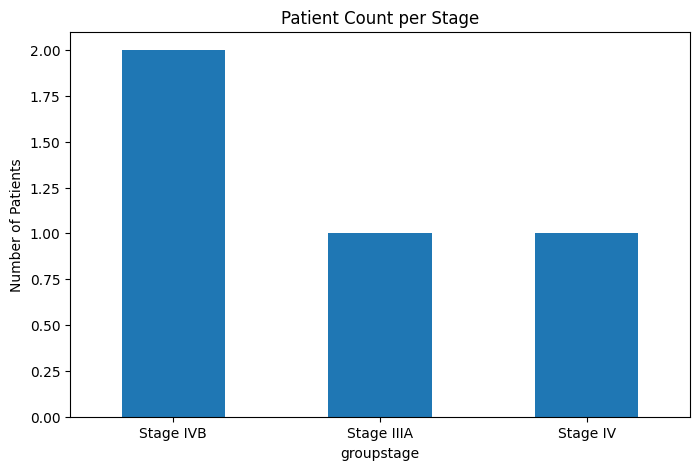

In [84]:
import matplotlib.pyplot as plt
stage_counts.plot(kind='bar', figsize=(8,5))
plt.xlabel("groupstage")
plt.ylabel("Number of Patients")
plt.title("Patient Count per Stage")
plt.xticks(rotation=0)
plt.show()